### Detect face's keypoints 

In [22]:
# !pip install tensorflow

### Librarys

In [23]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


### Data transform

In [24]:
class Cleaner(BaseEstimator, TransformerMixin):
  def __init__(self):
    super()
  
  def read_dataset(self, filename):
    X = pd.read_csv(filename)
    y = pd.DataFrame({X.shape[1]: np.arange(0, X.shape[0])//200})
    return X, y
  
  def show_image(self, image):
    plt.imshow(self.transform_image(image))
  
  def transform_image(self, image):
    return np.reshape(np.array(image.split(' '), dtype=int), (96,96,1))
  
  def plot_sample(self, image, keypoint, axis, title):
    # image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='o', s=20, color='r')
    plt.title(title)
    plt.show()
    
  def fit(self, X, y):
    return self
  
  def transform(self, X: pd.DataFrame, y=None):
    images = X["Image"].apply(self.transform_image)
    keys = X.drop("Image",axis = 1)
    keys.fillna(method = 'ffill' , inplace = True)
    print(keys.isnull().sum())

    return np.stack(images.to_numpy(), 0), keys.to_numpy()
  
  def fit_transform(self, X, y = None):
      return self.fit(X, y).transform(X, y)
  
class CustomMinMax(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.min_max = MinMaxScaler()
  def fit(self, X, y=None):
    # self.min_max.fit(y)
    return self
  def transform(self, X, y=None):
    return X[0]/255., X[1]
    # return X[0]/255., self.min_max.transform(X[1])
  def inverse_transform(self, X, y=None):
    return np.array(X*255, dtype=np.int8), self.min_max.inverse_transform(y)
  def fit_transform(self, X, y=None):
    return self.fit(X, y).transform(X, y)

In [25]:
cleaner = Cleaner()
file_name_train = "dataset/training.csv"
file_name_test = "dataset/test.csv"

train_data = pd.read_csv(file_name_train)
test_data = pd.read_csv(file_name_test)

train_data.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [26]:
train_data.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7039.000000,7039.000000,7036.000000,7036.000000,2271.000000,2271.000000,2267.000000,2267.000000,2268.000000,2268.000000,...,7049.000000,7049.000000,2269.000000,2269.000000,2270.000000,2270.000000,2275.000000,2275.000000,7016.000000,7016.000000
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,...,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
std,3.448233,3.152926,3.083230,3.033621,2.690354,2.307332,3.405852,2.881438,2.350268,2.311907,...,4.280038,5.720567,4.079063,4.579724,3.964552,4.417814,3.323060,5.222500,4.269961,5.407844
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,...,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082895,35.900451,28.783339,36.327681,58.039339,36.626283,71.716503,36.085523,35.506126,36.766783,...,46.602370,59.292697,61.257143,72.875707,30.797646,73.256472,46.494571,69.396748,46.573703,75.549715
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,...,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326
75%,68.024752,39.258449,31.768334,39.566729,60.519810,39.260348,75.015645,39.373489,37.753571,39.192917,...,50.330437,66.492686,65.376243,78.879123,35.101302,78.956357,49.296488,76.221644,50.677631,82.233993
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,...,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


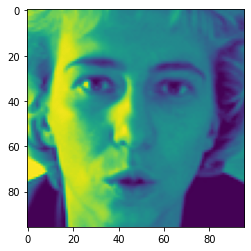

In [27]:
cleaner.show_image(train_data["Image"][1])

In [28]:
train_data.shape

(7049, 31)

In [29]:
limiar = .75
size_train = int(train_data.shape[0]*limiar)
pipeline = Pipeline([
  ("cleaner", cleaner),
  ("min_max", CustomMinMax()),
])
x_train, y_train = pipeline.fit_transform(train_data.iloc[:size_train], [])
x_valid, y_valid = pipeline.transform(train_data.iloc[size_train:])
# x_test, y_test = pipeline.transform(test_data)

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
dtype: int64
left_eye_center_x               0
left_eye_center_y      

In [30]:
x_train[0].shape

(96, 96, 1)

In [31]:
y_train

array([[66.03356391, 39.00227368, 30.22700752, ..., 72.93545865,
        43.13070677, 84.48577444],
       [64.33293617, 34.9700766 , 29.9492766 , ..., 70.26655319,
        45.46791489, 85.48017021],
       [65.05705263, 34.90964211, 30.90378947, ..., 70.19178947,
        47.27494737, 78.65936842],
       ...,
       [65.47474286, 39.11388571, 32.77672   , ..., 75.96359236,
        49.47856   , 74.39942857],
       [67.77685333, 36.53229867, 32.32107733, ..., 75.96359236,
        46.390816  , 71.98805333],
       [66.07473418, 38.92593418, 33.66404051, ..., 75.96359236,
        48.23392405, 68.66041519]])

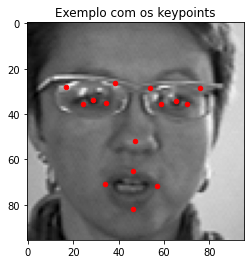

In [32]:
fig, ax = plt.subplots()
i = 10
cleaner.plot_sample(x_train[i], y_train[i], ax, "Exemplo com os keypoints")

In [49]:
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
    LeakyReLU,
    ReLU
)

In [50]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(96, 96, 1)))
model.add(LeakyReLU())
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(LeakyReLU())
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(LeakyReLU())
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128))
model.add(ReLU())
model.add(Dense(96))
model.add(ReLU())
model.add(Dense(64))
model.add(ReLU())
model.add(Dense(30))

In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
) 

In [52]:
min_max = MinMaxScaler()

In [53]:
# x_train.squeeze()
# x_train.T.shape
np.stack(x_train, 0).shape

(5286, 96, 96, 1)

In [54]:
y_train

array([[66.03356391, 39.00227368, 30.22700752, ..., 72.93545865,
        43.13070677, 84.48577444],
       [64.33293617, 34.9700766 , 29.9492766 , ..., 70.26655319,
        45.46791489, 85.48017021],
       [65.05705263, 34.90964211, 30.90378947, ..., 70.19178947,
        47.27494737, 78.65936842],
       ...,
       [65.47474286, 39.11388571, 32.77672   , ..., 75.96359236,
        49.47856   , 74.39942857],
       [67.77685333, 36.53229867, 32.32107733, ..., 75.96359236,
        46.390816  , 71.98805333],
       [66.07473418, 38.92593418, 33.66404051, ..., 75.96359236,
        48.23392405, 68.66041519]])

In [55]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 8
img_train = train_gen.flow(x_train, y_train, batch_size=batch_size)


In [56]:
np.expand_dims(x_valid, 1).shape

(1763, 1, 96, 96, 1)

In [57]:
train_gen.fit(x_train)

In [58]:
model.compile(optimizer='adam', loss='huber_loss', metrics=[tf.keras.metrics.Accuracy()])
# tf.keras.metrics.RootMeanSquaredError()

In [59]:
model.fit(img_train,
          epochs=1,
          steps_per_epoch=len(x_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(x_valid, y_valid))

582/660 [=========================>....] - ETA: 35s - loss: 5.2176 - accuracy: 0.0000e+00

KeyboardInterrupt: 